# Discussion of the GP marginal likelihood upper bound
Mark van der Wilk, Augustus 2017

These notes are discussed more comprehensively in my thesis (link to come).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

import GPflow

from FITCvsVFE import getTrainingTestData

In [2]:
X, Y, Xt, Yt = getTrainingTestData()

In [3]:
def plot_model(m, name=""):
    pX = np.linspace(-3, 9, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, 'x')
    plt.plot(pX, pY)
    try:
        plt.plot(m.Z.value, m.Z.value * 0, 'o')
    except AttributeError:
        pass
    two_sigma = (2.0 * pYv ** 0.5)[:, 0]
    plt.fill_between(pX[:, 0], pY[:, 0] - two_sigma, pY[:, 0] + two_sigma, alpha=0.15)
    lml = -m._objective(m.get_free_state())[0]
    plt.title("%s (lml = %f)" % (name, lml))
    return lml

## Full model

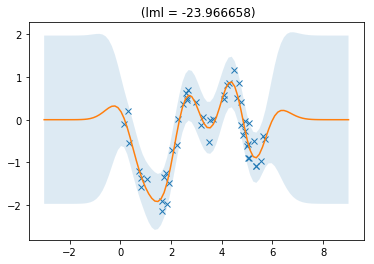

In [4]:
f = GPflow.gpr.GPR(X, Y, GPflow.kernels.RBF(1))
f.optimize()
full_lml = plot_model(f)

## Upper bounds for sparse variational models
As a first investigation, we compute the upper bound for models trained using the sparse variational GP approximation.

In [5]:
Ms = np.arange(4, 16, 1)
vfe_lml = []
vupper_lml = []
vfe_hyps = []
for M in Ms:
    try:
        Zinit = vfe.Z.value[:M, :].copy()
        Zinit = np.vstack((Zinit, X[np.random.permutation(len(X))[:(M - len(Zinit))], :].copy()))
        init_params = vfe.get_parameter_dict()
        init_params['model.Z'] = Zinit
        # init_params['model.kern.variance'] = 1.0
        # init_params['model.kern.lengthscales'] = 1.0
    except NameError:
        Zinit = X[:M, :].copy()
        init_params = None
    vfe = GPflow.sgpr.SGPR(X, Y, GPflow.kernels.RBF(1), Zinit)
    if init_params is not None:
        # We only do this to prevent bad local optima. Can also be avoided using random restarts
        vfe.set_parameter_dict(init_params)
        vfe._compile()
    vfe.optimize()
    
    upper = GPflow.sgpr.SGPU(X, Y, GPflow.kernels.RBF(1), vfe.Z.value.copy())
    params = vfe.get_parameter_dict()
    upper.set_parameter_dict(params)
    upper.kern.fixed = True
    upper.likelihood.fixed = True
    upper.optimize()
    
    vfe_lml.append(-vfe._objective(vfe.get_free_state())[0])
    vupper_lml.append(upper._objective(upper.get_free_state())[0])
    vfe_hyps.append(vfe.get_parameter_dict())
    print("%i" % M, end=" ")
vfe_hyps = pd.DataFrame(vfe_hyps)

4 5 6 7 8 9 10 11 12 13 14 15 

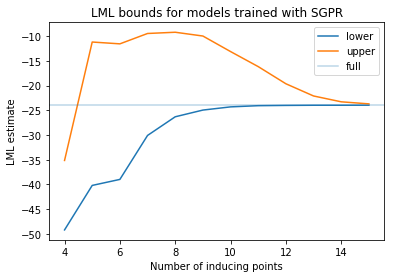

In [6]:
plt.plot(Ms, vfe_lml, label="lower")
plt.plot(Ms, vupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
plt.legend()
plt.title("LML bounds for models trained with SGPR")

We see that the lower bound increases as more inducing points are added. Note that the upper bound does _not_ monotonically decrease! This is because as we train the sparse model, we also get better estimates of the hyperparameters. The upper bound will be different for this different setting of the hyperparameters, and is sometimes looser. The upper bound also converges to the true lml slower than the lower bound.

## Upper bounds for fixed hyperparameters
Here, we train sparse models with the hyperparameters fixed to the optimal value found previously.

In [7]:
fMs = np.arange(3, 16, 1)
fvfe_lml = []  # Fixed vfe lml
fvupper_lml = []  # Fixed upper lml
for M in fMs:
    try:
        Zinit = vfe.Z.value[:M, :].copy()
        Zinit = np.vstack((Zinit, X[np.random.permutation(len(X))[:(M - len(Zinit))], :].copy()))
        init_params = vfe.get_parameter_dict()
        init_params['model.Z'] = Zinit
    except NameError:
        Zinit = X[:M, :].copy()
        init_params = None
    vfe = GPflow.sgpr.SGPR(X, Y, GPflow.kernels.RBF(1), Zinit)
    if init_params is not None:
        # We only do this to prevent bad local optima. Can also be avoided using random restarts
        vfe.set_parameter_dict(init_params)
        vfe._compile()
    vfe.kern.fixed = True
    vfe.likelihood.fixed = True
    vfe.optimize()
    
    upper = GPflow.sgpr.SGPU(X, Y, GPflow.kernels.RBF(1), vfe.Z.value.copy())
    params = vfe.get_parameter_dict()
    upper.set_parameter_dict(params)
    upper.kern.fixed = True
    upper.likelihood.fixed = True
    upper.optimize()
    
    fvfe_lml.append(-vfe._objective(vfe.get_free_state())[0])
    fvupper_lml.append(upper._objective(upper.get_free_state())[0])
    print("%i" % M, end=" ")

3 4 5 6 7 8 9 10 11 12 13 14 15 

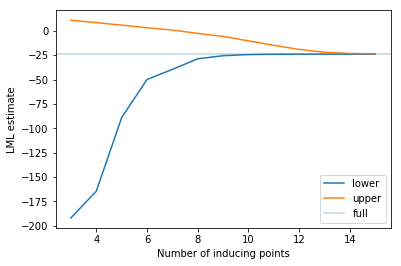

In [8]:
plt.plot(fMs, fvfe_lml, label="lower")
plt.plot(fMs, fvupper_lml, label="upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
plt.legend()

Now, as the hyperparameters are fixed, the bound _does_ monotonically decrease. We chose the optimal hyperparameters here, but the picture should be the same for any hyperparameter setting. This shows that we increasingly get a better estimate of the marginal likelihood as we add more inducing points.

## A tight estimate bound does not imply a converged model

In [9]:
vfe = GPflow.sgpr.SGPR(X, Y, GPflow.kernels.RBF(1), X[None, 0, :].copy())
vfe.optimize()
upper = GPflow.sgpr.SGPU(X, Y, GPflow.kernels.RBF(1), vfe.Z.value.copy())
params = vfe.get_parameter_dict()
upper.set_parameter_dict(params)
upper.kern.fixed = True
upper.likelihood.fixed = True
upper.optimize()

      fun: array([-62.48473627])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.85935699e-10])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 3
      nit: 2
   status: 0
  success: True
        x: array([ 3.36690111])

In [10]:
print("Lower bound: %f" % -vfe._objective(vfe.get_free_state())[0])
print("Upper bound: %f" % upper._objective(upper.get_free_state())[0])

Lower bound: -62.487090
Upper bound: -62.484736


In this case we show that for the hyperparameter setting, the bound _is_ tight. However, this does _not_ imply that we have enough inducing points, simply that we have correctly identified the marginal likelihood for this particular hyperparameter setting. In this specific case, where we used a single inducing point, the model collapses to not using the GP at all (lengthscale is really long to model only the mean). The rest of the variance is explained by noise. This GP can be perfectly approximated with a single inducing point.

In [11]:
vfe

Name,values,prior,constraint
model.Z,[[ 2.65740921]],None,(none)
model.kern.lengthscales,[ 1014.38504695],None,+ve
model.kern.variance,[ 0.10775259],None,+ve
model.likelihood.variance,[ 0.68243197],None,+ve


This can be diagnosed by showing that there are other hyperparameter settings with higher upper bounds. This indicates that there may be better hyperparameter settings, but we cannot identify them due to the lack of inducing points. An example of this can be seen in the previous section.

## Using the upper bound to identify FITC over-fitting

In [Bauer et al. 2016, *Understanding Probabilistic Sparse Gaussian Process Approximations*](http://papers.nips.cc/paper/6477-understanding-probabilistic-sparse-gaussian-process-approximations) some issues with FITC and VFE are analysed, particularly FITC's ability to over-fit. This generally manifests itself in:
- Under-estimated noise variances
- Over-estimated marginal likelihoods, particularly compared to the marginal likelihood of the hyperparameters that are estimated

Bauer et al. showed that this effect is most detrimental once a certain number of inducing points have been added. It would be ideal if the upper bound could identify these situations _before_ over-fitting and poor hyperparameter estimation kicks in. Spoiler: The bound is often not tight enough, but can be used in situations with larger numbers of inducing points.

In [12]:
fMs = np.arange(3, 16, 1)
fupper_lml = []
fitc_lml = []
fitc_hyps = []
try:
    del fitc
except NameError:
    pass
for M in fMs:
    try:
        Zinit = fitc.Z.value[:M, :].copy()
        Zinit = np.vstack((Zinit, X[np.random.permutation(len(X))[:(M - len(Zinit))], :].copy()))
        init_params = fitc.get_parameter_dict()
        init_params['model.Z'] = Zinit
    except NameError:
        Zinit = X[:M, :].copy()
        init_params = None
    
    # fitc = GPflow.sgpr.GPRFITC(X, Y, GPflow.kernels.RBF(1), X[:M, :].copy())
    fitc = GPflow.sgpr.GPRFITC(X, Y, GPflow.kernels.RBF(1), Zinit)
    # if init_params is not None:
    #     fitc.set_parameter_dict(init_params)
    fitc.optimize()
    
    upper = GPflow.sgpr.SGPU(X, Y, GPflow.kernels.RBF(1), fitc.Z.value.copy())
    upper.set_parameter_dict(fitc.get_parameter_dict())
    upper.Z = vfe.Z.value[:M, :]  # FITC tends to clump inducing points. VFE gives a better initialisation.
    upper.kern.fixed = True
    upper.likelihood.fixed = True
    upper.optimize()
    
    fupper_lml.append(upper._objective(upper.get_free_state())[0])
    fitc_lml.append(-fitc._objective(fitc.get_free_state())[0])
    fitc_hyps.append(fitc.get_parameter_dict())
    print("%i" % M, end=" ")
fitc_hyps = pd.DataFrame(fitc_hyps)

3 4 5 6 7 8 9 10 11 12 13 14 15 

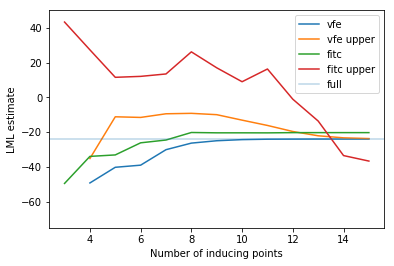

In [14]:
plt.plot(Ms, vfe_lml, label="vfe")
plt.plot(Ms, vupper_lml, label="vfe upper")
plt.plot(fMs, fitc_lml, label="fitc")
plt.plot(fMs, fupper_lml, label="fitc upper")
plt.axhline(full_lml, label="full", alpha=0.3)
plt.xlabel("Number of inducing points")
plt.ylabel("LML estimate")
plt.ylim(-75, 50)
plt.legend()

We see that once enough inducing points are added, the upper bound for the hyperparameters that FITC found becomes lower than the reported marginal likelihood. This proves that FITC is over-estimating the marginal likelihood without having to compute the full GP. However, the proof of over-estimation requires more inducing variables than FITC needs to start over-estimating the marginal likelihood. So, while interesting, this does not provide a silver bullet that always identifies when FITC over-fits.

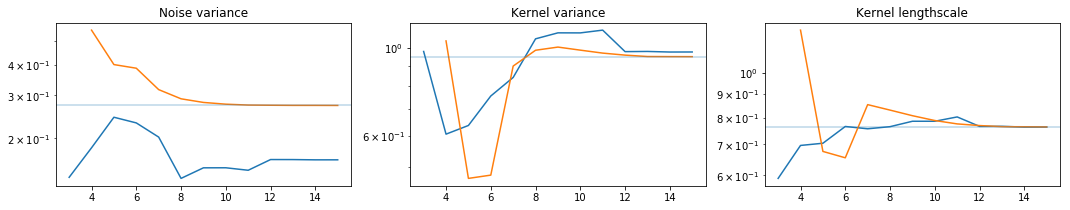

In [13]:
plt.figure(figsize=(18, 3))
plt.subplot(131)
plt.plot(fMs, np.vstack(fitc_hyps['model.likelihood.variance']) ** 0.5)
plt.plot(Ms, np.vstack(vfe_hyps['model.likelihood.variance']) ** 0.5)
plt.axhline(f.likelihood.variance.value ** 0.5, alpha=0.3)
plt.yscale('log')
plt.title("Noise variance")
plt.subplot(132)
plt.plot(fMs, np.vstack(fitc_hyps['model.kern.variance']) ** 0.5)
plt.plot(Ms, np.vstack(vfe_hyps['model.kern.variance']) ** 0.5)
plt.axhline(f.kern.variance.value ** 0.5, alpha=0.3)
plt.yscale('log')
plt.title("Kernel variance")
plt.subplot(133)
plt.plot(fMs, np.vstack(fitc_hyps['model.kern.lengthscales']) ** 0.5)
plt.plot(Ms, np.vstack(vfe_hyps['model.kern.lengthscales']) ** 0.5)
plt.axhline(f.kern.lengthscales.value ** 0.5, alpha=0.3)
plt.yscale('log')
plt.title("Kernel lengthscale")